In [1]:
import pandas as pd
import numpy as np
import os
from pcntoolkit.dataio.fileio import load as ptkload
from pcntoolkit.dataio.fileio import save as ptksave

import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
import matplotlib as mpl
from pathlib  import Path
import matplotlib.ticker as ticker

import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("husl", 9)

# globals
root_dir = '/project_cephfs/3022017.06/ENIGMA_ANX/'
proc_dir = os.path.join(root_dir,'Z_stat/')
data_dir = os.path.join(proc_dir,'data/')
w_dir = os.path.join(proc_dir,'vox/')
save_dir = os.path.join(w_dir,'Validation/')
mask_nii = ('/opt/fmriprep/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_mask.nii.gz')
ex_nii = os.path.join(data_dir, 'ENIGMA_FC_tr_1.nii.gz')

/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load in the Z_est files
Z_est_control_test = ptkload(os.path.join(w_dir,'Z_estimate.pkl'), mask=mask_nii)
Z_est_clinical = ptkload(os.path.join(w_dir,'Z_predcl.pkl'), mask=mask_nii)
Full_sample_deviations = np.append(Z_est_control_test,Z_est_clinical, axis = 0)

#Load in the contingency awareness data
Measures = pd.read_csv('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/data/all_test_validation.csv', usecols = ["Group_Dataset", 
                                                                                                                "Anxiety_instrument",
                                                                                                                "Anxiety_score",
                                                                                                                "Depression_instrument",
                                                                                                                "Depression_score", 
                                                                                                                'Principal_diagnosis_current']) 
Measures.replace(to_replace='NA/does not apply', value='NA', regex=True, inplace=True)

Measures['Anxiety_score'] = pd.to_numeric(Measures['Anxiety_score'], errors='coerce').astype('Int64')
Measures['Depression_score'] = pd.to_numeric(Measures['Depression_score'], errors='coerce').astype('Int64')


# FOR STAI- SPANISH VERSION: add 20 to make scale the same as others:
spanish_STAI_sites = ["Barcelona_Cardoner", "Barcelona_Soriano_dataset_1", "Barcelona_Soriano_dataset_2"]
# Check if instrument_value is 1 and the Group_Dataset is in the specified list
for index, row in Measures.iterrows():
    if row['Group_Dataset'] in spanish_STAI_sites and Measures.at[index, 'Anxiety_instrument'] == 'stai-trait':
        # Modify Anxiety_score by adding 20
        Measures.at[index, 'Anxiety_score'] += 20


#Mask by participants for whom CA data is available
mask_Anx = Measures["Anxiety_score"].notna() #remove NAs
mask_select_measure = Measures['Anxiety_instrument'].isin(['stai-trait']) #CHANGE THIS TO QUESTIONNIARE OF INTEREST
#beck anxiety inventory
#hamilton anxiety
#other (scared total score)
#other (staic)
#stai-state
#stai-trait

mask_exclude_diagnosis = ~Measures['Principal_diagnosis_current'].isin(['others', 'schizophrenia']) #and remove others and schizophrenia
combined_mask_Anx = mask_Anx & mask_exclude_diagnosis 
combined_mask_Anx = combined_mask_Anx & mask_select_measure

Anx_sample = Measures['Anxiety_score'][combined_mask_Anx].to_numpy()
Anx_sample_deviations = Full_sample_deviations[combined_mask_Anx]
print('Anxiety data available for: '+str(len(Anx_sample)) +' people')
print(Anx_sample)

mask_Dep = Measures["Depression_score"].notna() #remove NAs
combined_mask_Dep = mask_Dep & mask_exclude_diagnosis

Dep_sample = Measures['Depression_score'][combined_mask_Dep].to_numpy()
Dep_sample_deviations = Full_sample_deviations[combined_mask_Dep]
print('Depression data available for: '+str(len(Dep_sample)) +' people')
print(Dep_sample)

Anxiety data available for: 751 people
[35 59 34 22 24 37 35 41 26 45 40 30 31 28 27 45 42 31 44 43 49 26 31 22
 53 28 35 23 51 27 23 33 42 29 32 36 29 32 42 38 33 39 29 40 60 40 26 31
 37 47 21 58 34 30 43 37 34 31 34 32 34 25 41 39 27 44 29 38 46 35 52 36
 47 29 39 27 40 24 34 26 44 43 48 28 48 24 23 35 39 44 34 21 37 24 44 21
 43 38 35 33 42 40 40 56 46 41 41 48 22 52 69 55 59 58 71 66 55 39 52 57
 65 58 67 62 47 58 72 63 48 58 73 54 62 58 38 61 37 48 41 37 56 46 39 23
 32 57 40 53 45 47 51 28 45 41 41 38 52 36 34 44 35 55 39 34 40 39 29 36
 27 24 22 51 45 34 34 23 31 25 43 43 35 34 34 22 45 31 33 36 24 43 35 46
 35 46 29 32 53 35 45 56 33 65 49 62 37 48 45 63 34 24 58 72 45 39 61 62
 60 51 58 44 47 52 26 30 36 29 34 26 39 35 35 41 30 34 29 30 31 40 41 36
 34 26 55 42 29 42 38 39 38 41 55 41 32 29 32 36 25 30 28 25 29 25 46 54
 25 38 50 32 45 27 32 30 54 33 31 39 39 44 34 46 53 30 21 34 57 22 30 45
 37 36 37 49 22 38 30 59 38 42 25 27 34 35 28 30 28 29 28 31 37 55 26 42
 42 35 26 23

In [3]:
#Define parameters
X1 = Anx_sample_deviations #Deviations
y = Anx_sample.ravel()
n_samples, n_features = X1.shape
random_state = np.random.RandomState(0)


In [4]:
#%%ELASTIC NET CV

from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

from sklearn.model_selection import train_test_split


model_alpha = []
model_intercept = []

ypred_cf = []
score_cf = []
ev_cf = []
mse_cf = []
coefs_cf = []

for i in range(0,10):
    print('Iteration',i)

    alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
    xtrain, xtest, ytrain, ytest = train_test_split(X1, y, test_size=0.1)
    
    #ElasticNetCV is a cross-validation class that can search multiple alpha values 
    #and applies the best one. We'll define the model with alphas value and fit 
    #it with xtrain and ytrain data.
    
    elastic_cv=ElasticNetCV(alphas=alphas, cv=5)
    model = elastic_cv.fit(xtrain, ytrain)
    
    print(model.alpha_)
    model_alpha.append(model.alpha_)
    print(model.intercept_)
    model_intercept.append(model.intercept_)
    
    ypred = model.predict(xtest)
    score = model.score(xtest, ytest)
    ev = explained_variance_score(ytest, ypred)
    mse = mean_squared_error(ytest, ypred)
    print("R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}"
          .format(score, mse, np.sqrt(mse)))
    
    
    ypred_cf.append(ypred)
    score_cf.append(score)
    ev_cf.append(ev)
    mse_cf.append(mse)
    coefs_cf.append(model.coef_)
    
combined_elastic_net = pd.DataFrame(list(zip(score_cf, ev_cf, mse_cf, model_intercept)),
                                    columns=['R2','EV', 'MSE', 'Model_Intercept']) 
combined_elastic_net.to_csv(os.path.join(save_dir,('Anxiety_stai_trait_Elastic_Net.csv')))


mean_coefs = np.mean(coefs_cf, axis = 0)
ptksave(mean_coefs, os.path.join(save_dir,('Anxiety_stai_trait_mean.nii.gz')), example=ex_nii, mask=mask_nii)


median_coefs = np.median(coefs_cf, axis = 0)
ptksave(median_coefs, os.path.join(save_dir,('Anxiety_stai_trait_median.nii.gz')), example=ex_nii, mask=mask_nii)


coefs_cf = np.array(coefs_cf)
freq_coefs = (coefs_cf > 0.0001).sum(axis=0) >= 5
ptksave(coefs_cf, os.path.join(save_dir,('Anxiety_stai_trait_coefs.nii.gz')), example=ex_nii, mask=mask_nii)

binary_mask = (coefs_cf > 0.005).sum(axis=0) >= 5
ptksave(binary_mask, os.path.join(save_dir,('Anxiety_stai_trait_gt5_mask.nii.gz')), example=ex_nii, mask=mask_nii)
count_array = (coefs_cf > 0.0001).sum(axis=0)
ptksave(count_array, os.path.join(save_dir,('Anxiety_stai_trait_count.nii.gz')), example=ex_nii, mask=mask_nii)



Iteration 0


/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.031e+01, tolerance: 6.165e+00
  model = cd_fast.enet_coordinate_descent(
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.047e+01, tolerance: 6.674e+00
  model = cd_fast.enet_coordinate_descent(


1.0
37.67886031754802
R2:-0.108, MSE:148.55, RMSE:12.19
Iteration 1


/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.176e+01, tolerance: 6.719e+00
  model = cd_fast.enet_coordinate_descent(
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.962e+01, tolerance: 6.719e+00
  model = cd_fast.enet_coordinate_descent(
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

1.0
37.85678761076268
R2:-0.044, MSE:113.25, RMSE:10.64
Iteration 2


/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.228e+01, tolerance: 6.221e+00
  model = cd_fast.enet_coordinate_descent(
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.659e+01, tolerance: 6.810e+00
  model = cd_fast.enet_coordinate_descent(
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

1.0
37.86464911511695
R2:0.051, MSE:99.44, RMSE:9.97
Iteration 3


/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.312e+01, tolerance: 6.355e+00
  model = cd_fast.enet_coordinate_descent(
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.422e+01, tolerance: 6.597e+00
  model = cd_fast.enet_coordinate_descent(
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

1.0
37.93094101830079
R2:-0.110, MSE:130.06, RMSE:11.40
Iteration 4


/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.108e+00, tolerance: 6.572e+00
  model = cd_fast.enet_coordinate_descent(
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.226e+01, tolerance: 6.572e+00
  model = cd_fast.enet_coordinate_descent(
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

1.0
37.9853097120572
R2:-0.221, MSE:123.23, RMSE:11.10
Iteration 5


/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.997e+00, tolerance: 6.162e+00
  model = cd_fast.enet_coordinate_descent(
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.720e+00, tolerance: 6.453e+00
  model = cd_fast.enet_coordinate_descent(
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

1.0
37.86718894750465
R2:-0.092, MSE:125.99, RMSE:11.22
Iteration 6


/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.396e+01, tolerance: 6.220e+00
  model = cd_fast.enet_coordinate_descent(
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.036e+01, tolerance: 6.610e+00
  model = cd_fast.enet_coordinate_descent(
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

1.0
37.90191483293038
R2:0.060, MSE:119.62, RMSE:10.94
Iteration 7


/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.779e+01, tolerance: 6.296e+00
  model = cd_fast.enet_coordinate_descent(
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.141e+01, tolerance: 6.553e+00
  model = cd_fast.enet_coordinate_descent(
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

1.0
37.333010668632
R2:-0.232, MSE:173.42, RMSE:13.17
Iteration 8


/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.350e+00, tolerance: 6.406e+00
  model = cd_fast.enet_coordinate_descent(
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.798e+01, tolerance: 6.406e+00
  model = cd_fast.enet_coordinate_descent(
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

1.0
37.8531835060518
R2:-0.061, MSE:109.74, RMSE:10.48
Iteration 9


/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.690e+00, tolerance: 6.767e+00
  model = cd_fast.enet_coordinate_descent(
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.005e+01, tolerance: 6.923e+00
  model = cd_fast.enet_coordinate_descent(
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

1.0
37.61940021337649
R2:-0.216, MSE:141.89, RMSE:11.91


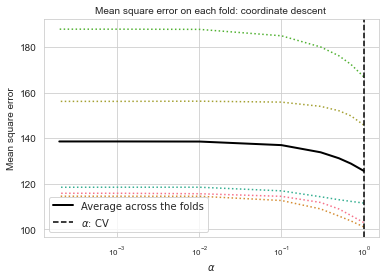

<Figure size 1500x1500 with 0 Axes>

In [5]:
#%%
EPSILON = 1e-4  # This is to avoid division by zero while taking the base 10 logarithm
fpath = Path("/project_cephfs/3022017.06/ENIGMA_ANX/arial.ttf")

plt.figure()
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
plt.semilogx(model.alphas_ + EPSILON, model.mse_path_, ':')
plt.plot(model.alphas_ + EPSILON, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(model.alpha_ + EPSILON, linestyle='--', color='k',
            label=r'$\alpha$: CV')
plt.legend()
plt.yticks(font = fpath)
plt.xticks(size = 8, font = fpath)
plt.xlabel(r'$\alpha$', font = fpath)
plt.ylabel('Mean square error', font = fpath)
plt.title('Mean square error on each fold: coordinate descent ', font = fpath)
plt.axis('tight')
plt.show()
plt.savefig('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/plots/Anxiety_stai_trait_ElasticNetCV5.png', dpi=300)


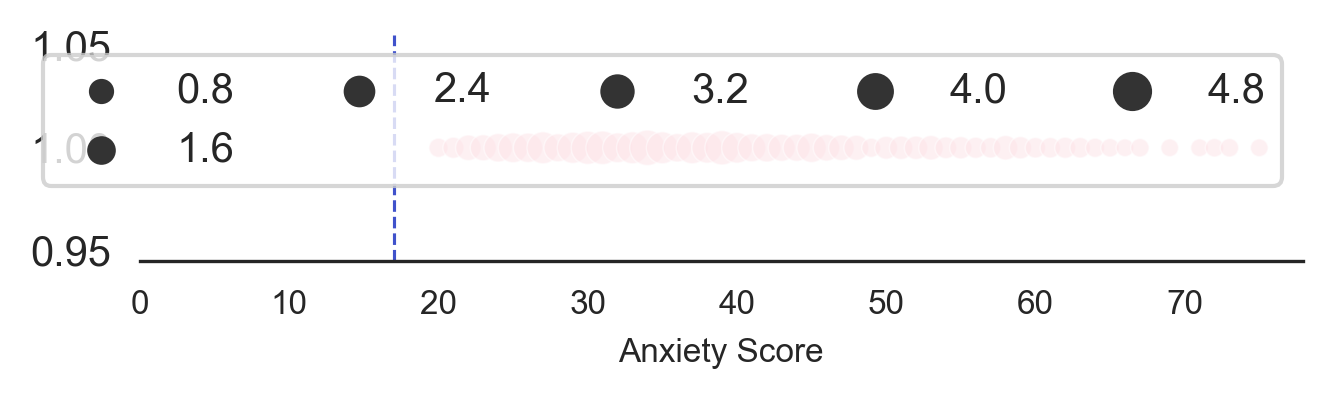

In [6]:
#%%PLOT ANXIETY SCORES
# Set up the font path
unique, counts = np.unique(y, return_counts=True)
# Assuming unique is a NumPy array or a list
unique = np.array(unique)

# Create an array of ones with the same length as unique
y_values = np.ones(len(unique))


fpath = Path("/project_cephfs/3022017.06/ENIGMA_ANX/arial.ttf")

# Set up the figure and axis
sns.set_style("white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 1
fig, ax = plt.subplots()
# Plot the stacked bar chart
plt.ylim=(0.95, 1.05)
sns.scatterplot(x = unique, y = y_values, y_jitter = 10, size = (counts/sum(counts)*100), alpha = 0.5)# palette=dict('1'="#B7092C", '2'="#F7B192", '3'="#B9D0FA", '4'='#4052CB'), )


#Add line for clinical threshold
#Mapping: 
#                            {'NA' : 'NA', 
#                            'stai-trait' : 40,  20-80
#                            'other (masq - anxious arousal)' : ,  
#                            'stai-state' : ,
#                            'hamilton anxiety': 17, 0-56
#                            'other (scared total score)' : 25,  0-82
#                            'other (dass-21_anxiety subscale)': 
#                            'other (staic)': , 
#                            'beck anxiety inventory': , 
#                            'others': }  

plt.axvline(x = 17,    # Line on x = clinical cut off
           ymin = 0, # Bottom of the plot
           ymax = 1, 
           color = "#4052CB",
           linestyle = "--",
           linewidth = 0.75) # Top of the plot

# Add labels and title
plt.yticks(font = fpath)
plt.xticks(size = 8, font = fpath)
ax.set_xticks([0, 10, 20, 30, 40, 50])
#ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80])
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.set_xlabel('Anxiety Score', font = fpath, size = 8)
sns.despine(top=True, left=True, bottom=False, right = True)

plt.legend(loc = 'best', prop=fpath, ncol=5)
#plt.legend().set_visible(False)

# Show the plot
plt.show()
fig.savefig('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/plots/Anxiety_stai_trait_withlegend.png', dpi=300)